# Determine optimal number of clusters

In [1]:
import os
# Set environment variables to disable multithreading
# as users will probably want to set the number of cores
# to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [2]:
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

from astroExplain.spectra import clustering
from sdss.metadata import MetaData

meta = MetaData()

# Custom functions

In [3]:
def plot_inertias_silhouettes(
    inertias,
    silhouettes,
    n_clusters,
    subtitle='',
):
    fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
    axs[0].plot(range(2, n_clusters), inertias, '-o')
    axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')

    # Add major and minor ticks
    for ax in axs:
        # major ticks every 2
        ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
        # minor ticks every 1
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
        ax.grid(True, which='major', linestyle='--', alpha=0.7)
        ax.grid(True, which='minor', linestyle=':', alpha=0.4)
    # Add labels
    axs[0].set_ylabel("Inertia")
    axs[1].set_ylabel("Silhouette Score")

    # Shared x-label and title
    fig.supxlabel("Number of Clusters")
    fig.suptitle(
        "Clustering Metrics vs Number of Clusters\n"
        f"{subtitle}"
    )

    return fig, axs


# Data ingestion

In [4]:
bin_id = "bin_03"
phd_dir = "/home/elom/phd"
spectra_dir = f"{phd_dir}/00_phd_code/spectra"
explanations_dir = f"{phd_dir}/00_phd_code/explanations"
paper_figures_dir = f"{phd_dir}/00_paper_explain-me-why/sections/figures/"
wave = np.load(f"{spectra_dir}/wave_spectra_imputed.npy")


# MSE explanation weights

In [5]:
mse_dict = {
    "metric": "mse_noRel100",
    "run_id": "20250427190650_uniform_5000_scale",
    "weights": None,
    "unique_weights": None,
}

mse_dict["weights"] = np.load(
    f"{explanations_dir}/{bin_id}/"
    f"{mse_dict['metric']}/weights_{mse_dict['run_id']}.npy"
)

mse_dict["unique_weights"] = clustering.get_weights_per_segments(
    weights=mse_dict["weights"],
    n_segments=128
)

Base size: 29, Residual size: 61
New number of segments: 129


In [31]:
n_wave = wave.shape[0]
print(f"Number of wavelengths: {n_wave}")
divmod(n_wave, 128), divmod(n_wave, 198), 

Number of wavelengths: 3773


((29, 61), (19, 11))

## Unit vector normalization

### raw normalization

Normalization took 0.00 seconds
Run time: 20.78 seconds


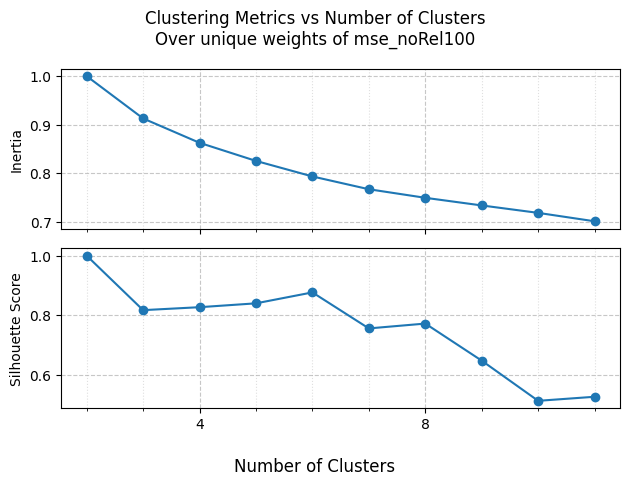

In [ ]:
X = mse_dict["unique_weights"]
X = normalize(X, norm='l2', axis=1)

n_clusters = 12

inertias, silhouette_scores = clustering.compute_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)

subptitle = (
    f"Over unique weights of {mse_dict['metric']}"
)
fig, axs = plot_inertias_silhouettes(
    inertias=inertias,
    silhouettes=silhouette_scores,
    n_clusters=n_clusters,
    subtitle=subptitle
)
plt.tight_layout()
plt.show()

# fig.savefig(
#     f"{explanations_dir}/{bin_id}/{score_name}/"
#     f"clustering_metrics_raw_unique_weights_{explanation_run_id}.pdf"
# )
# fig.savefig(
#     f"{explanations_dir}/{bin_id}/{score_name}/"
#     f"clustering_metrics_raw_unique_weights_{explanation_run_id}.jpeg"
# )


### Absolute value of normalization

Normalization took 0.01 seconds
Run time: 20.18 seconds


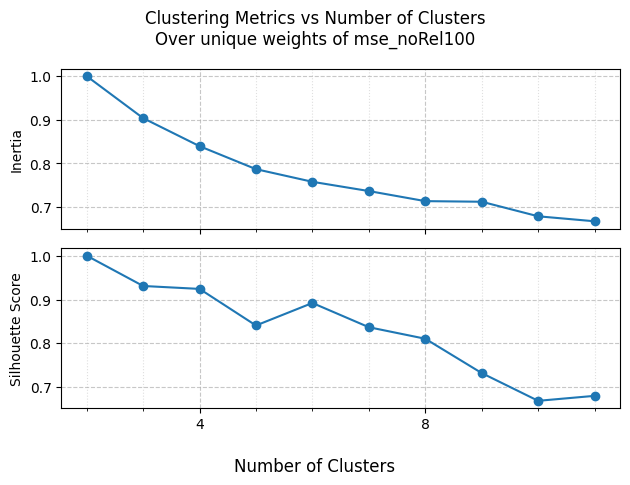

In [ ]:
X = mse_dict["unique_weights"]
X = np.abs(X)
X = normalize(X, norm='l2', axis=1)

n_clusters = 12

inertias, silhouette_scores = clustering.compute_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)

subptitle = (
    f"Over unique weights of {mse_dict['metric']}"
)
fig, axs = plot_inertias_silhouettes(
    inertias=inertias,
    silhouettes=silhouette_scores,
    n_clusters=n_clusters,
    subtitle=subptitle
)
plt.tight_layout()
plt.show()

# fig.savefig(
#     f"{explanations_dir}/{bin_id}/{score_name}/"
#     f"clustering_metrics_raw_unique_weights_{explanation_run_id}.pdf"
# )
# fig.savefig(
#     f"{explanations_dir}/{bin_id}/{score_name}/"
#     f"clustering_metrics_raw_unique_weights_{explanation_run_id}.jpeg"
# )


## Unique raw explanation weights

Run time: 18.61 seconds


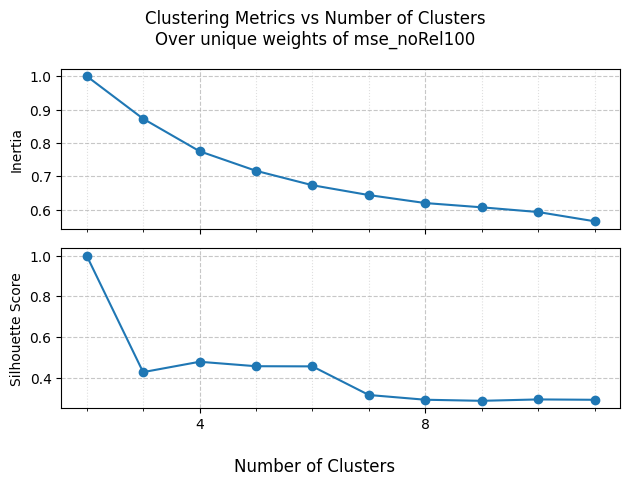

In [ ]:
X = mse_dict["unique_weights"]
n_clusters = 12

inertias, silhouette_scores = clustering.compute_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)

subptitle = (
    f"Over unique weights of {mse_dict['metric']}"
)
fig, axs = plot_inertias_silhouettes(
    inertias=inertias,
    silhouettes=silhouette_scores,
    n_clusters=n_clusters,
    subtitle=subptitle
)
plt.tight_layout()
plt.show()

# fig.savefig(
#     f"{explanations_dir}/{bin_id}/{score_name}/"
#     f"clustering_metrics_raw_unique_weights_{explanation_run_id}.pdf"
# )
# fig.savefig(
#     f"{explanations_dir}/{bin_id}/{score_name}/"
#     f"clustering_metrics_raw_unique_weights_{explanation_run_id}.jpeg"
# )


## Absolute value of unique explanation weights

Base size: 29, Residual size: 61
New number of segments: 129
Run time: 36.61 seconds


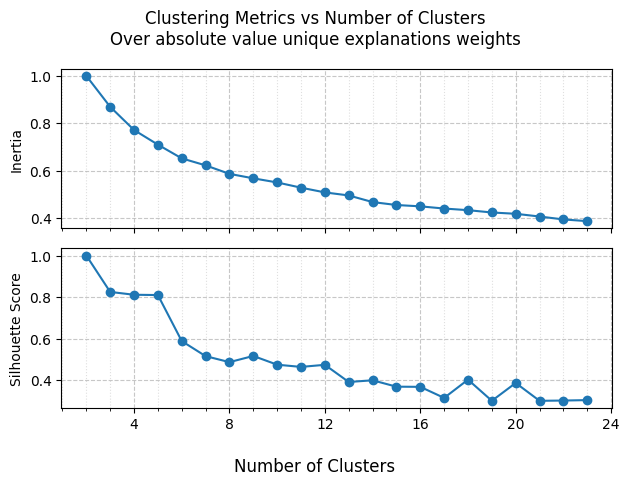

In [ ]:
X = get_weights_per_segments(weights=weights, n_segments=128)
X = np.abs(X)
n_clusters = 24

inertias, silhouette_scores = compute_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(range(2, n_clusters), inertias, '-o')
axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')

# Add major and minor ticks
for ax in axs:
    # major ticks every 2
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    # minor ticks every 1
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', alpha=0.4)
# Add labels
axs[0].set_ylabel("Inertia")
axs[1].set_ylabel("Silhouette Score")

# Shared x-label and title
fig.supxlabel("Number of Clusters")
fig.suptitle(
    "Clustering Metrics vs Number of Clusters\n"
    "Over absolute value unique explanations weights",
    # fontsize=14
)

plt.tight_layout()
plt.show()

fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_abs_unique_weights_{explanation_run_id}.pdf"
)
fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_abs_unique_weights_{explanation_run_id}.jpeg"
)
# Base size: 29, Residual size: 61
# New number of segments: 129
# Run time: 36.61 seconds


## Normalized (row level) absolute value unique explanation weights

Base size: 29, Residual size: 61
New number of segments: 129
Run time: 38.95 seconds


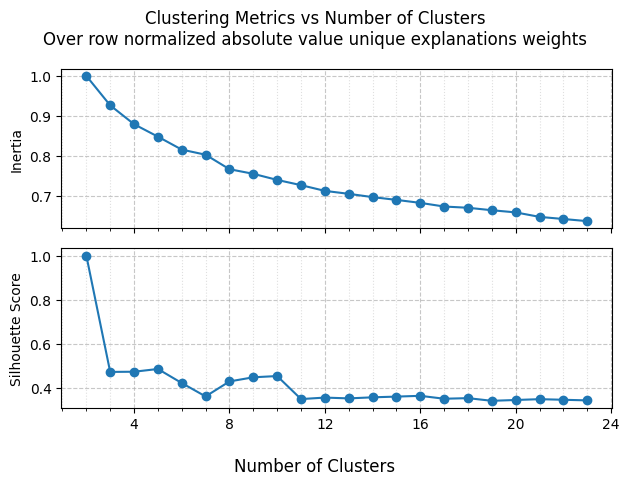

In [19]:
X = get_weights_per_segments(weights=weights, n_segments=128)
X = np.abs(X)/np.max(np.abs(X), axis=1, keepdims=True)

n_clusters = 24

inertias, silhouette_scores = compute_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias /= np.max(inertias)
silhouette_scores /= np.max(silhouette_scores)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(range(2, n_clusters), inertias, '-o')
axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')

# Add major and minor ticks
for ax in axs:
    # major ticks every 2
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    # minor ticks every 1
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', alpha=0.4)
# Add labels
axs[0].set_ylabel("Inertia")
axs[1].set_ylabel("Silhouette Score")

# Shared x-label and title
fig.supxlabel("Number of Clusters")
fig.suptitle(
    "Clustering Metrics vs Number of Clusters\n"
    "Over row normalized absolute value unique explanations weights",
    # fontsize=14
)

plt.tight_layout()
plt.show()

fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_norm_row_abs_unique_weights_{explanation_run_id}.pdf"
)
fig.savefig(
    f"{explanations_dir}/{bin_id}/{score_name}/"
    f"clustering_metrics_norm_row_abs_unique_weights_{explanation_run_id}.jpeg"
)